In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [96]:
states = [
    "jakarta", "bandung", "dieng", "jogjakarta", "sukabumi", "bogor",
    "malang", "banyuwangi", "mojokerto", "surabaya"
]
N = len(states)
edges = [
    ("jakarta", "bandung", 108.98), 
    ("jakarta", "bogor", 47.12),
    ("jakarta", "sukabumi", 80.55), 
    ("bandung", "dieng", 255.56),
    ("bogor", "dieng", 349.69),
    ("sukabumi", "jogjakarta", 393.26),
    ("mojokerto", "surabaya", 42.10),
    ("bogor", "jogjakarta", 417.58),
    ("jogjakarta", "mojokerto", 227.83),
    ("banyuwangi", "surabaya", 209.75),
    ("banyuwangi", "jogjakarta", 441.51),
    ("jogjakarta", "malang", 248.32),
    ("malang", "surabaya", 82.13),
    ("malang", "dieng", 312.99),
    ("mojokerto", "dieng", 280.60),
    ("dieng", "banyuwangi", 505.16)
]
edges_distances = np.array(list(map(lambda x: x[2], edges))).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(10, 90))
edges_distances = scaler.fit_transform(edges_distances)
edges_distances.reshape(1, -1)[0]
scaled_edges = []
for i in range(len(edges)):
    scaled_edges.append(
        (edges[i][0], edges[i][1], round(edges_distances.reshape(1, -1)[0][i], 2))
    )
edges = scaled_edges

In [97]:
start = "jakarta"
goal = "surabaya"

In [98]:
G = nx.Graph()
G.add_edges_from(list(map(lambda x: (x[0], x[1]), edges)))

In [99]:
position = nx.spring_layout(G, seed=121)

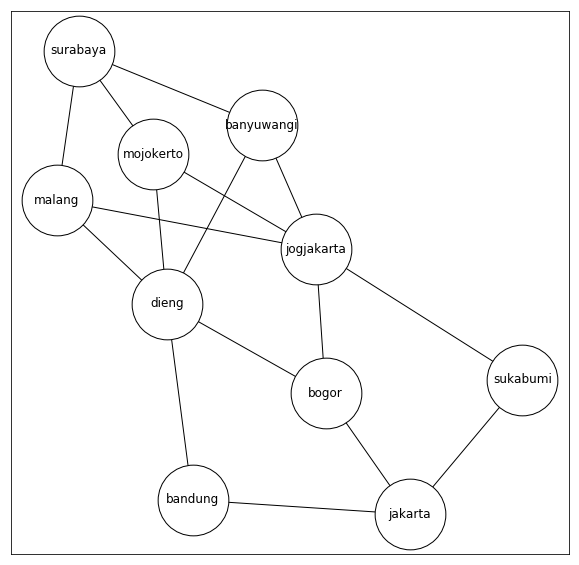

In [100]:
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, position, node_size=5000, node_color="w", edgecolors="k")
nx.draw_networkx_edges(G, position)
nx.draw_networkx_labels(G, position)
plt.show()

In [101]:
R = pd.DataFrame(-np.ones((N, N)), index=states, columns=states)
R

,jakarta,bandung,dieng,jogjakarta,sukabumi,bogor,malang,banyuwangi,mojokerto,surabaya
jakarta,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
bandung,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
dieng,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
jogjakarta,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
sukabumi,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
bogor,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
malang,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
banyuwangi,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
mojokerto,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
surabaya,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [102]:
for a, b,c in edges:
    R.loc[a, b] = 100 if b == goal else 100 - c
    R.loc[b, a] = 100 if a == goal else 100 - c
R.loc[goal, goal] = 100
R

,jakarta,bandung,dieng,jogjakarta,sukabumi,bogor,malang,banyuwangi,mojokerto,surabaya
jakarta,-1.00,78.45,-1.00,-1.00,83.36,89.13,-1.00,-1.00,-1.00,-1.0
bandung,78.45,-1.00,53.12,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0
dieng,-1.00,53.12,-1.00,-1.00,-1.00,36.86,43.20,10.00,48.80,-1.0
jogjakarta,-1.00,-1.00,-1.00,-1.00,29.33,25.13,54.37,21.00,57.91,-1.0
sukabumi,83.36,-1.00,-1.00,29.33,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0
bogor,89.13,-1.00,36.86,25.13,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0
malang,-1.00,-1.00,43.20,54.37,-1.00,-1.00,-1.00,-1.00,-1.00,100.0
banyuwangi,-1.00,-1.00,10.00,21.00,-1.00,-1.00,-1.00,-1.00,-1.00,100.0
mojokerto,-1.00,-1.00,48.80,57.91,-1.00,-1.00,-1.00,-1.00,-1.00,100.0
surabaya,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,83.08,61.04,90.00,100.0


In [103]:
Q = pd.DataFrame(np.zeros((N, N)), index=states, columns=states)
Q

,jakarta,bandung,dieng,jogjakarta,sukabumi,bogor,malang,banyuwangi,mojokerto,surabaya
jakarta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dieng,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jogjakarta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sukabumi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bogor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
malang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
banyuwangi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mojokerto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
surabaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
temp = R[start]

In [105]:
temp[temp >= 0].index

Index(['bandung', 'sukabumi', 'bogor'], dtype='object')

In [106]:
def step(state):
    """
    R = Reward table
    r = action reward
    """
    r = R[state]
    available_actions = r[r >= 0].index
    return np.random.choice(available_actions)

In [107]:
def update(state, action, gamma=0.8):
    """
    Q = Q-table
    q = action quality
    """
    q = Q[state]
    maxq = q.max()
    
    #kasus untuk maxq lebih dari 1
    mask = (q == maxq)
    if mask.sum() > 1:
        maxq = np.random.choice(q[mask])
    Q.loc[state, action] = R.loc[state, action] + (gamma * maxq)

In [108]:
state = start

In [109]:
action = step(state)
action

'sukabumi'

In [110]:
update(state, action)

In [111]:
Q = pd.DataFrame(np.zeros((N, N)), index=states, columns=states)

In [112]:
for _ in range(3000):
    state = np.random.choice(states)
    while state == start:
        state = np.random.choice(states)
    action = step(state)
    update(state, action, gamma=0.9)

In [113]:
Q

,jakarta,bandung,dieng,jogjakarta,sukabumi,bogor,malang,banyuwangi,mojokerto,surabaya
jakarta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bandung,887.486273,0.000000,862.156273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dieng,0.000000,898.929192,0.000000,0.000000,0.000000,882.674256,889.014256,855.814256,894.614256,0.000000
jogjakarta,0.000000,0.000000,0.000000,0.000000,883.343256,879.143256,908.383256,875.013256,911.923256,0.000000
sukabumi,878.368930,0.000000,0.000000,824.338930,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bogor,883.536830,0.000000,831.266830,819.532273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
malang,0.000000,0.000000,927.966256,939.136256,0.000000,0.000000,0.000000,0.000000,0.000000,984.761192
banyuwangi,0.000000,0.000000,874.930256,885.929618,0.000000,0.000000,0.000000,0.000000,0.000000,964.930256
mojokerto,0.000000,0.000000,939.793618,948.903618,0.000000,0.000000,0.000000,0.000000,0.000000,990.994256
surabaya,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,983.073618,961.033618,989.994256,999.993618


In [114]:
Q/Q.values.max()

,jakarta,bandung,dieng,jogjakarta,sukabumi,bogor,malang,banyuwangi,mojokerto,surabaya
jakarta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bandung,0.887492,0.000000,0.862162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dieng,0.000000,0.898935,0.000000,0.000000,0.000000,0.882680,0.889020,0.855820,0.894620,0.000000
jogjakarta,0.000000,0.000000,0.000000,0.000000,0.883349,0.879149,0.908389,0.875019,0.911929,0.000000
sukabumi,0.878375,0.000000,0.000000,0.824344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bogor,0.883542,0.000000,0.831272,0.819538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
malang,0.000000,0.000000,0.927972,0.939142,0.000000,0.000000,0.000000,0.000000,0.000000,0.984767
banyuwangi,0.000000,0.000000,0.874936,0.885935,0.000000,0.000000,0.000000,0.000000,0.000000,0.964936
mojokerto,0.000000,0.000000,0.939800,0.948910,0.000000,0.000000,0.000000,0.000000,0.000000,0.991001
surabaya,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.983080,0.961040,0.990001,1.000000


In [115]:
step = [start]
while step[-1] != goal:
    q = Q[step[-1]]
    mask = (q == q.max())
    if mask.sum() > 1:
        step.append(np.random.choice(q[mask].index))
    else:
        step.append(q.idxmax())
print(step)

['jakarta', 'bandung', 'dieng', 'mojokerto', 'surabaya']
